# Adult brain measure estimation from BLS data
As BLS is not publicly available due to ethical considerations, no data is included in this repository. The code is provided as a reference for the analysis of the BLS data. 

In [1]:
%load_ext autoreload
%autoreload 2

# Data preparation
This whole notebook should be run for cortical thickness (CT) or surface area (SA). Both measures were used in the original publication. Adjust the variable `brain_measure` to `CT` or `SA` accordingly. 

In [ ]:
import os
from os.path import join
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, chi2_contingency, mannwhitneyu

from abagen import fetch_desikan_killiany
from neuroCombat import neuroCombat

import matplotlib.pyplot as plt
import seaborn as sns

# import custom code
import sys
sys.path.append('code')
from utils import reorder_vars
from preprocessing import load_freesurfer_aparc, load_freesurfer_aseg, calculate_scanner_difference
from euler import euler_hemi_combination, get_euler_outliers

bls_data_dir = 'data/BLS'
bls_freesurfer_outputs = join(bls_data_dir, 'freesurfer')  # where all freesurfer outputs are stored
qc_dir_bls26 = join(bls_data_dir, 'euler_BLS-26')  # where FreeSurfer QC files are stored
bls_out = join(bls_data_dir, 'derivatives')  # where the adapted data will be stored
os.makedirs(bls_out, exist_ok=True)


# adjust brain measurement for which the code should be run
brain_measure = 'CT'  # CT or SA

# Load MRI related data

In [3]:
# brain_measure
if brain_measure == 'CT':
    mri_data_lh = load_freesurfer_aparc(file = join(bls_freesurfer_outputs, 'BLS-26_thickness_fs7.3.2_lh.txt'))
    mri_data_rh = load_freesurfer_aparc(file = join(bls_freesurfer_outputs, 'BLS-26_thickness_fs7.3.2_rh.txt'))
    mri_data = mri_data_lh.merge(mri_data_rh, on='participant')
    #mri_data.drop(columns=['lh_MeanThickness_thickness', 'rh_MeanThickness_thickness'], inplace=True)
    mri_data.rename(columns={'lh_MeanThickness_thickness':'lh_mean_CT2', 'rh_MeanThickness_thickness':'rh_mean_CT2'}, inplace=True)
    bls_idps_idx = mri_data.filter(regex='_thickness').columns.to_list()
    
elif brain_measure == 'SA':
    mri_data_lh = load_freesurfer_aparc(file = join(bls_freesurfer_outputs, 'BLS-26_surfaceArea_fs7.3.2_lh.txt'))
    mri_data_rh = load_freesurfer_aparc(file = join(bls_freesurfer_outputs, 'BLS-26_surfaceArea_fs7.3.2_rh.txt'))
    mri_data = mri_data_lh.merge(mri_data_rh, on='participant')
    mri_data.drop(columns=['lh_WhiteSurfArea_area', 'rh_WhiteSurfArea_area'], inplace=True)
    bls_idps_idx = mri_data.filter(regex='_area').columns.to_list()
    
else:
    raise ValueError('brain_measure has to be either CT or SA')


# aseg
aseg = load_freesurfer_aseg(file = os.path.join(bls_freesurfer_outputs, 'BLS-26_aseg_fs7.3.2.txt'))
aseg = aseg[['participant', 'EstimatedTotalIntraCranialVol','TotalGrayVol','SubCortGrayVol','CerebralWhiteMatterVol']]    

# meta
meta = pd.read_csv(join(bls_data_dir, 'BLS-26_meta_cleaned.csv'))
meta = meta[['participant', 'blsgroup','phenotype','age', 'sex','sex_code','Scanner_ID',
            'GA', 'BW', 'dnti', 
            'SES_at_birth', 'PIRI',
            'wie_gesiq', 'hemo']]


# merge
bls_26 = meta.merge(mri_data, on='participant')
bls_26 = bls_26.merge(aseg, on='participant')


In [4]:
# access DK atlas and save idp_labels
atlas = fetch_desikan_killiany(surface=True)
atlas = pd.read_csv(atlas['info'])
atlas = atlas[(atlas['structure'] == 'cortex') & (atlas['hemisphere'] == 'L')]
atlas_labels_l = ['L_'+label for label in atlas['label']]
atlas_labels_r = ['R_'+label for label in atlas['label']]

desikan_idps = atlas_labels_l + atlas_labels_r
print(f"Number of IDPs: {len(bls_idps_idx)}")

Number of IDPs: 68


In [5]:
# rename columns
bls_26 = bls_26.rename(columns=dict(
        wie_gesiq="IQ", 
        SubCortGrayVol="sGMV",
        TotalGrayVol="GMV",
        EstimatedTotalIntraCranialVol="eTIV",
        CerebralWhiteMatterVol="WMV"
))
bls_26 = bls_26.rename(columns=dict(zip(bls_idps_idx, desikan_idps)))

## Quality control using Euler Index
Freesurfer's Euler number is a measure of the topological complexity of the reconstructed cortical surface. The Euler number is expected to be 2 for a closed surface. Freesurfer's Euler number has previously been used to identify subjects with poor quality reconstructions. Some informative publications are listed below:
- [Rosen 2018](https://doi.org/10.1016/j.neuroimage.2017.12.059) 
- [Bethlehem 2022](https://doi.org/10.1038/s41586-022-04554-y)

The Euler Index can be extracted with *mris_euler_index* from the recon-all output.

In [6]:
# combine Euler Indices across hemispheres
euler_hemi_combination(euler_file=join(qc_dir_bls26, 'QC_output_BLS-26.txt'), outdir=qc_dir_bls26, dataset_name='BLS-26')

# calculate outliers based on Euler Indices
outliers = get_euler_outliers(join(qc_dir_bls26, 'QC_output_combined_BLS-26.txt'), outdir=qc_dir_bls26, threshold=4.5)

# adapt excluded subjects after manual QC
outliers.append('BEST-BN-009')  # this subject does not have information for gestational age and was thus excluded

# do not exclude outliers that passed manual QC
outliers.remove('BEST-BN-005')
outliers.remove('BEST-MUC-014')

# get outlier complete df
outlier_data = bls_26[bls_26['participant'].isin(outliers)]
outlier_data['blsgroup']

with open(join(bls_data_dir, f'BLS-26_{brain_measure}_excluded_subjects.txt'), 'w') as f:
    for item in outliers:
        f.write("%s\n" % item)

Median of Euler indices: -90.0
Median absolute deviation (MAD): 20.0
Euler index histogram saved to: data/BLS/euler_BLS-26/euler_histogram.png


In [7]:
# actually exclude the outliers
print("Data shape before exclusion:", bls_26.shape)
bls_26 = bls_26[~bls_26['participant'].isin(outliers)]

print("New size of data:", bls_26.shape)

Data shape before exclusion: (211, 88)
New size of data: (203, 88)


In [8]:
# save separate hemisphere data for supplementary analysis
bls_26.to_csv(join(bls_out, f'BLS-26_{brain_measure}_raw.csv'), index=False)

## Average hemispheres

In [9]:
regions = [r[2:] for r in desikan_idps[:34]]

# Combine L_ and R_ values
for region in regions:
    bls_26[f'{brain_measure}_{region}'] = bls_26[[f'L_{region}', f'R_{region}']].mean(axis=1)
    # drop L_ and R_ columns
    bls_26 = bls_26.drop(columns=[f'L_{region}', f'R_{region}'])

# create region list bilateral    
desikan_idps_bilateral = [f'{brain_measure}_{region}' for region in regions]
ctv_columns = ['GMV', 'WMV', 'sGMV', 'eTIV']

if brain_measure == 'CT':
    bls_26['meanCT2'] = bls_26[['lh_mean_CT2', 'rh_mean_CT2']].mean(axis=1)
    bls_26.drop(columns=['lh_mean_CT2', 'rh_mean_CT2'], inplace=True)
    desikan_idps_bilateral.append('meanCT2')

# NeuroCombat for data harmonization
Longitudinal data acquisition took place at different scanners for the BLS study. Therefore, cross-sectional instead of longitudinal Combat was used for data harmonization. This will done separately for `brain_measure` and cerebral tissue volume measures due to different scales.

In [10]:
# make sure data is ordered correctly
bls_26 = bls_26.sort_values(by='participant')
subject_ids = bls_26['participant'].values

In [11]:
# separate brain_measure and cerebral tissue volumes for Combat
bls_26_data = bls_26[desikan_idps_bilateral]
bls_26_ctv = bls_26[ctv_columns]
covars = bls_26.drop(columns=desikan_idps_bilateral+ctv_columns)
covars['diagnosis'] = covars['phenotype'].map({'preterm': 1, 'term': 0})

## Harmonize `brain_measure` data
Sex and age are included as covariates in the model.

In [12]:
combat = neuroCombat(dat=bls_26_data.values.transpose(),  # required data format by combat
                    covars=covars,
                    batch_col=['Scanner_ID'],
                    categorical_cols=['sex_code', 'diagnosis'],
                    continuous_cols=['age']) 
data_combat = combat['data']

data_combat = pd.DataFrame(data_combat.transpose(), columns=desikan_idps_bilateral, index=subject_ids)
data_combat.index.name = 'participant'

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


## Harmonize cerebral tissue volumes

In [13]:
combat = neuroCombat(dat=bls_26_ctv.values.transpose(),  # required data format by combat
                    covars=covars,
                    batch_col=['Scanner_ID'],
                    categorical_cols=['sex_code', 'diagnosis'],
                    continuous_cols=['age']) 
data_combat_ctv = combat['data']

data_combat_ctv = pd.DataFrame(data_combat_ctv.transpose(), columns=ctv_columns, index=subject_ids)
data_combat_ctv.index.name = 'participant'

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


In [14]:
# combine outputs 
bls_26_combat = covars.merge(data_combat, on='participant')
bls_26_combat = bls_26_combat.merge(data_combat_ctv, on='participant')

## Combat harmonization stats
Calculate the scanner difference between sites before and after harmonization using an ANCOVA model.

In [15]:
# before
bls_26_terms = bls_26[bls_26['phenotype'] == 'term']
combat_stats_before = calculate_scanner_difference(bls_26_terms, desikan_idps_bilateral, scanner_var='Scanner_ID', 
                                                    covars=['age', 'sex_code'])

In [16]:
# after
data_combat_terms = bls_26_combat[bls_26_combat['diagnosis'] == 0]
combat_stats_after = calculate_scanner_difference(data_combat_terms, desikan_idps_bilateral, scanner_var='Scanner_ID', 
                                                    covars=['age', 'sex_code'])

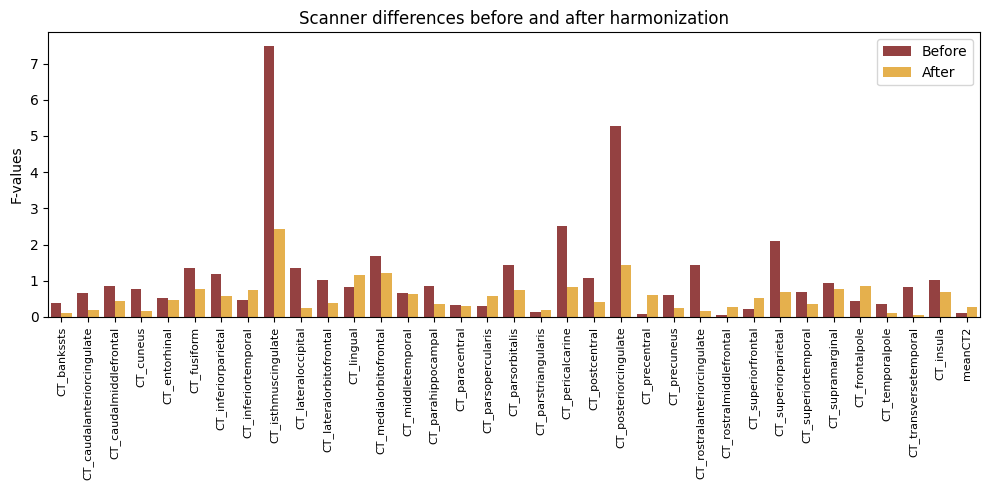

In [17]:
# Combine data with identifier column
combat_stats_before['Harmonization'] = 'Before'
combat_stats_after['Harmonization'] = 'After'
combined_stats = pd.concat([combat_stats_before, combat_stats_after])

# Create plot
fig, ax = plt.subplots(figsize=(10, 5))
plt.ioff()

# Create grouped barplot
sns.barplot(
    data=combined_stats,
    x='ROI',
    y='F-values',
    hue='Harmonization',
    palette={'Before': 'darkred', 'After': 'orange'},
    alpha=0.8
)

# Formatting
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('')
plt.title('Scanner differences before and after harmonization', fontsize=12)
plt.legend(title='')
plt.tight_layout()
plt.show()

# Adapt df for BrainChart framework
BrainChart needs a certain format of the data. We will adapt the data accordingly. More information can be found [here](https://brainchart.shinyapps.io/brainchart/).

In [18]:
bls_26_combat = bls_26_combat.rename(columns=dict(
    id="participant",
    age="Age",
)) 

# age
bls_26_combat['age_days'] = (bls_26_combat.Age * 365.245) + 280  # from BrainChart instructions

# sex
bls_26_combat['sex'] = bls_26_combat['sex'].map({'female':'Female', 'male':'Male'})

# dx
bls_26_combat['dx'] = bls_26_combat['diagnosis'].map({1: 'preterm', 0: 'CN'})

# other columns
bls_26_combat['study'] = 'BLS-26'
bls_26_combat['fs_version'] = 'Custom'
bls_26_combat['country'] = 'Multisite'
bls_26_combat['run'] = 1
bls_26_combat['session'] = 1

# drop columns
bls_26_combat.drop(columns=['phenotype', 'diagnosis', 'sex_code','Scanner_ID', 'blsgroup'], inplace=True)

# reshape and rename last things
bls_26_final = reorder_vars(['participant', 'Age', 'age_days', 'sex', 'study', 'fs_version','country', 'run', 
                            'session', 'dx'], bls_26_combat, desikan_idps_bilateral)
bls_26_final.rename(columns={'EstimatedTotalIntraCranialVol': 'eTIV'}, inplace=True)

In [19]:
# save
bls_26_final.to_csv(join(bls_out, f'BLS-26_{brain_measure}_preprocessed.csv'), index=False)

# Stats
Summary stats shown in Supp Table S1.

In [20]:
print("Overall number of unique subjects with longitudinal data: n =", len(bls_26_final))

bls_26_final_pt = bls_26_final[bls_26_final['dx'] == 'preterm']
bls_26_final_cn = bls_26_final[bls_26_final['dx'] == 'CN']

print('Preterm stats: n = ', len(bls_26_final_pt))
print(bls_26_final_pt['sex'].value_counts())
display(bls_26_final_pt[['Age', 'GA', 'BW', 'IQ']].describe().round(2))
print(bls_26_final_pt['SES_at_birth'].value_counts())


Overall number of unique subjects with longitudinal data: n = 203
Preterm stats: n =  96
Male      53
Female    43
Name: sex, dtype: int64


,Age,GA,BW,IQ
count,96.00,96.00,96.00,92.00
mean,26.75,30.49,1324.43,93.99
std,0.60,2.16,319.18,12.80
min,25.71,25.00,630.00,64.00
25%,26.26,29.00,1075.00,85.00
50%,26.68,30.00,1375.00,94.00
75%,27.24,31.00,1500.00,100.00
max,28.34,36.00,2070.00,131.00


2.0    42
3.0    28
1.0    26
Name: SES_at_birth, dtype: int64


In [21]:
print('Full-term stats: n = ', len(bls_26_final_cn))
print(bls_26_final_cn['sex'].value_counts())
display(bls_26_final_cn[['Age', 'GA', 'BW', 'IQ']].describe().round(2))
print(bls_26_final_cn['SES_at_birth'].value_counts())

Full-term stats: n =  107
Male      62
Female    45
Name: sex, dtype: int64


,Age,GA,BW,IQ
count,107.00,107.00,107.00,104.00
mean,26.82,39.70,3399.90,102.41
std,0.72,1.06,451.55,11.93
min,25.49,37.00,2120.00,77.00
25%,26.31,39.00,3130.00,94.75
50%,26.75,40.00,3410.00,102.00
75%,27.33,40.00,3700.00,110.00
max,28.90,42.00,4670.00,130.00


2.0    48
1.0    33
3.0    26
Name: SES_at_birth, dtype: int64


In [ ]:
# test significance
contingency_table = pd.crosstab(bls_26_final['dx'], bls_26_final['sex'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-squared test for sex difference between groups: Chi={chi2:.3f}, p-value: {p:.3f}")

t, p = ttest_ind(bls_26_final_pt['Age'], bls_26_final_cn['Age'], nan_policy='omit', equal_var=True)
print(f"t-test for Age at scan: t={t:.3f}, p-value: {p:.3f}")

t, p = ttest_ind(bls_26_final_pt['IQ'], bls_26_final_cn['IQ'], nan_policy='omit', equal_var=True)
print(f"t-test for IQ scores: t={t:.3f}, p-value: {p:.2e}")

t, p = ttest_ind(bls_26_final_pt['GA'], bls_26_final_cn['GA'], nan_policy='omit', equal_var=True)
print(f"t-test for GA scores: t={t:.3f}, p-value: {p:.2e}")

t, p = ttest_ind(bls_26_final_pt['BW'], bls_26_final_cn['BW'], nan_policy='omit', equal_var=True)
print(f"t-test for BW scores: t={t:.3f}, p-value: {p:.2e}")

stat, p = mannwhitneyu(bls_26_final_pt['SES_at_birth'], bls_26_final_cn['SES_at_birth'], alternative='two-sided')
print(f"Mann-Whitney U test for SES at birth scores: U={stat:.3f}, p-value: {p:.3f}")



Chi-squared test for sex difference between groups: Chi=0.063, p-value: 0.802
t-test for Age at scan: t=-0.691, p-value: 0.490
t-test for IQ scores: t=-4.769, p-value: 3.64e-06
t-test for GA scores: t=-39.241, p-value: 3.55e-96
t-test for BW scores: t=-37.418, p-value: 1.60e-92
Mann-Whitney U test for SES at birth scores: U=5455.000, p-value: 0.414
